# xgboost and Tabular data
## update tabular-trees notebook with xgboost and data preperation


See: 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier

This is done with a 15m data set. 

Another approaches are: 
- 1 minute data set (2 std and 0.1% profit)
- more months
- do some descriptive data on MA length and when prices are out of BB range
- extending the dependent variable to more periods, so that the X% rise or fall occurs in the next e.g. 2-5 candles and not in the next candle 

In [1]:
# import data from septembre of 2022 since it was rather stable during this period
import pandas as pd
import numpy as np
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    df = pd.read_csv("/kaggle/input/btcusdt-2023-6-9/btcusdt-2023-6_9.csv", index_col=0).reset_index(drop=True)
else:
    df = pd.read_csv("btc-data/btcusdt-2023-6_9.csv", index_col=0).reset_index(drop=True)

print(df.shape)
df.head(3)

(11716, 6)


,time,open,high,low,close,vol
0,2023.06.01 00:00,27103.1,27108.1,27080.6,27096.9,386.675
1,2023.06.01 00:15,27096.9,27096.9,27036.7,27047.0,408.680
2,2023.06.01 00:30,27047.0,27077.4,27041.0,27054.9,275.080


In [46]:
df["open"][0]

27103.1

In [2]:
# show that one can calculate the vol and vol_coin numbers from the API call 1
print(386.675*((27108.1+27080.6)/2))

# take average of high and low and then multiply by vol_coin (which is available)
#  vol        vol_coin
#, '200082', '2.81566749'
2.81566749*((71063+71053)/2) 

10476707.786249999


200075.70050442

In [3]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'vol'], dtype='object')

In [4]:
len(df.high)

11716

In [5]:
df_ = pd.read_csv("btc-data/btcusdt-2023-6_9.csv", index_col=0).reset_index(drop=True)
df_.drop_duplicates(subset = ["time"],inplace = True)
len(df_)

11713

In [6]:
df_
df_["open_1"] = df_["open"].shift(1)
df_.head(5)

,time,open,high,low,close,vol,open_1
0,2023.06.01 00:00,27103.1,27108.1,27080.6,27096.9,386.675,NaN
1,2023.06.01 00:15,27096.9,27096.9,27036.7,27047.0,408.680,27103.1
2,2023.06.01 00:30,27047.0,27077.4,27041.0,27054.9,275.080,27096.9
3,2023.06.01 00:45,27054.9,27084.0,27054.8,27084.0,218.143,27047.0
4,2023.06.01 01:00,27084.0,27113.9,27073.5,27100.0,329.412,27054.9


In [7]:
# remove duplicates (every 1st entry of new data set was the same as last =3 duplicates)
df.drop_duplicates(subset = ["time"],inplace = True)
print(len(df))

# clear column names of whitespaces etc. for renaming purposes
df.columns = df.columns.str.strip()

# rename vol to vol_coin bc of API call consistency data mapping (vol is in paper currency)
df.rename(columns={"vol": "vol_coin"},inplace=True)


# idx = 0
# new_col = [7, 8, 9]  # can be a list, a Series, an array or a scalar   
# df.insert(loc=idx, column='A', value=new_col)

# add vol of coin in dollar currency
vol = df.vol_coin * ((df.high+df.low)/2)

df.insert(loc = 5, column = "vol",  value=vol)


11713


In [8]:
df.head(1) # now the mapping is in line with the API call structure 

,time,open,high,low,close,vol,vol_coin
0,2023.06.01 00:00,27103.1,27108.1,27080.6,27096.9,1.047671e+07,386.675


In [9]:
# transform to date_time
df["time"] = pd.to_datetime(df["time"])

# Extracting day and hour
df["day"] = df["time"].dt.day
df["hour"] = df["time"].dt.hour

df.head(1)

,time,open,high,low,close,vol,vol_coin,day,hour
0,2023-06-01,27103.1,27108.1,27080.6,27096.9,1.047671e+07,386.675,1,0


In [10]:
# the 10-day moving average
df["10MA"] = df["close"].rolling(window=10).mean()

# Calculate the standard deviation of the closing prices over the same 20-day period
df["10STD"] = df["close"].rolling(window=10).std()

# volume weighted close price
df["vwap"] = df.close/df.vol

# Bollinger Band: 
# simple_moving_average(20) + std x 2 | sma - std x 2
df["bb_upper_band"] = df["10MA"] + 2 * df["10STD"]
df["bb_lower_band"] = df["10MA"] - 2 * df["10STD"]

# daily_open
# df["daily_open"] = df.groupby(df["day"])["open"].transform("first")

# daily_close
# df["daily_close"] = df.groupby(df["day"])["close"].transform("first")


# Calculate On-Balance Volume (OBV)
df["change"] = df["close"].diff(periods=-1)
df["direction"] = df["change"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df["obv"] = df["vol"] * df["direction"]
df["obv"] = df["obv"].cumsum()

In [11]:
cols = ["open","high","low","close","vol","vol_coin","vwap","obv","change","direction"]

shifted_columns = {}

for i in range(12):
    for col in cols: 
        shifted_columns[col+"_"+str(i-3)] = df[col].shift(i)


# Concatenate the original DataFrame with the new shifted columns DataFrame
final_cols = ['time', 'day', 'hour', '10MA', '10STD', 'bb_upper_band','bb_lower_band']
shifted_df = pd.concat([df[final_cols], pd.DataFrame(shifted_columns)], axis=1)
shifted_df.columns

Index(['time', 'day', 'hour', '10MA', '10STD', 'bb_upper_band',
       'bb_lower_band', 'open_-3', 'high_-3', 'low_-3',
       ...
       'open_8', 'high_8', 'low_8', 'close_8', 'vol_8', 'vol_coin_8', 'vwap_8',
       'obv_8', 'change_8', 'direction_8'],
      dtype='object', length=127)

In [12]:
print(len(shifted_df.columns))

127


In [13]:
shifted_df.columns[:40]

Index(['time', 'day', 'hour', '10MA', '10STD', 'bb_upper_band',
       'bb_lower_band', 'open_-3', 'high_-3', 'low_-3', 'close_-3', 'vol_-3',
       'vol_coin_-3', 'vwap_-3', 'obv_-3', 'change_-3', 'direction_-3',
       'open_-2', 'high_-2', 'low_-2', 'close_-2', 'vol_-2', 'vol_coin_-2',
       'vwap_-2', 'obv_-2', 'change_-2', 'direction_-2', 'open_-1', 'high_-1',
       'low_-1', 'close_-1', 'vol_-1', 'vol_coin_-1', 'vwap_-1', 'obv_-1',
       'change_-1', 'direction_-1', 'open_0', 'high_0', 'low_0'],
      dtype='object')

In [14]:
shifted_df.head()

,time,day,hour,10MA,10STD,bb_upper_band,bb_lower_band,open_-3,high_-3,low_-3,...,open_8,high_8,low_8,close_8,vol_8,vol_coin_8,vwap_8,obv_8,change_8,direction_8
0,2023-06-01 00:00:00,1,0,NaN,NaN,NaN,NaN,27103.1,27108.1,27080.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-01 00:15:00,1,0,NaN,NaN,NaN,NaN,27096.9,27096.9,27036.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-06-01 00:30:00,1,0,NaN,NaN,NaN,NaN,27047.0,27077.4,27041.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-06-01 00:45:00,1,0,NaN,NaN,NaN,NaN,27054.9,27084.0,27054.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-06-01 01:00:00,1,1,NaN,NaN,NaN,NaN,27084.0,27113.9,27073.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

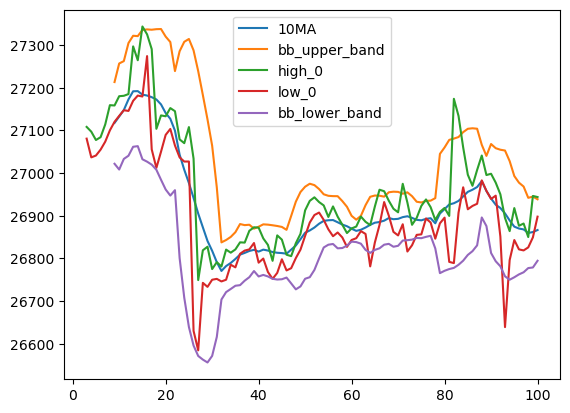

In [15]:
shifted_df.loc[0:100,["10MA","bb_upper_band","high_0","low_0","bb_lower_band"]].plot()

## dependent variable

In [16]:
df_xg = shifted_df.dropna()

# Create a new column "y_bb" initialized with False
df_xg.loc[:, ["y_bb_down","y_bb_up"]] = False

In [17]:
# GOAL:
# if the price is outside of the bollinger bands: 
#    is one of the next three candle 0.5% away from the bb value?


df_xg.loc[
    (df_xg["close_0"] < df_xg["bb_lower_band"]) &
    (df_xg[["high_-1", "high_-2", "high_-3"]].gt(df_xg["bb_lower_band"] * 1.002, axis=0).any(axis=1)), 
    "y_bb_down"
] = True

df_xg.loc[
    (df_xg["close_0"] > df_xg["bb_upper_band"]) &
    (df_xg[["low_-1", "low_-2", "low_-3"]].lt(df_xg["bb_upper_band"] / 1.002, axis=0).any(axis=1)), 
    "y_bb_up"
] = True

In [18]:
# little showcase how "any" works in this scenario: 
# we have two cols and "any" checks if there is any true in any of these cols
pd.DataFrame({"A": [True, False], "B": [False,False ]}).any(axis=1)

0     True
1    False
dtype: bool

In [19]:
print(len(df_xg), 100*((df_xg.y_bb_down.sum()+df_xg.y_bb_up.sum())/len(df_xg)))
print(df_xg.y_bb_down.sum())
print(df_xg.y_bb_up.sum())
print(df_xg.y_bb_down.sum()+df_xg.y_bb_up.sum())

11701 0.6580634133834715
38
39
77


In [20]:
print(len(df_xg[ (df_xg.y_bb_down == True)  &  (df_xg.close_0 < df_xg.bb_lower_band) ]))
print(len(df_xg[ (df_xg.y_bb_up == True)  &  (df_xg.close_0 > df_xg.bb_upper_band) ]))

38
39


In [21]:
df_xg.loc[:, "y_bb"] = df_xg.loc[:,["y_bb_down", "y_bb_up"]].any(axis=1)

/tmp/ipykernel_6829/835649938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xg.loc[:, "y_bb"] = df_xg.loc[:,["y_bb_down", "y_bb_up"]].any(axis=1)


In [22]:
df_xg.y_bb.sum()

77

**REFRAME FRAGESTELLUNG FÜR 15m candles:**

Hat die nächste Candle ein low unter BB und die nächsten dreh Candles ein high mit Profit?

...also ist nicht die candle der auslöser sondern die nächste.

In [23]:
df_xg.loc[:, ["y_bb_down_test","y_bb_up_test"]] = False

In [24]:
# GOAL:
# if the price is outside of the bollinger bands: 
#    is one of the next three candle 0.5% away from the bb value?


df_xg.loc[
    (df_xg["low_-1"] < df_xg["bb_lower_band"]) &
    (df_xg[["high_-1", "high_-2", "high_-3"]].gt(df_xg["bb_lower_band"] * 1.002, axis=0).any(axis=1)), 
    "y_bb_down_test"
] = True

df_xg.loc[
    (df_xg["high_-1"] > df_xg["bb_upper_band"]) &
    (df_xg[["low_-1", "low_-2", "low_-3"]].lt(df_xg["bb_upper_band"] / 1.002, axis=0).any(axis=1)), 
    "y_bb_up_test"
] = True

In [25]:
print(len(df_xg), 100*((df_xg.y_bb_down_test.sum()+df_xg.y_bb_up_test.sum())/len(df_xg)))
print(df_xg.y_bb_down_test.sum())
print(df_xg.y_bb_up_test.sum())
print(df_xg.y_bb_down_test.sum()+df_xg.y_bb_up_test.sum())

11701 12.725408084779078
796
693
1489


In [26]:
len(df_xg.query('y_bb_up_test == True and y_bb_down_test == True'))

24

24 entries are above and below signals which is not much but I need a clear signal. 

Besides this, I need also an up or down signal for the entry, TP, SL parameters to pass on.

In [27]:
# this line has both signals inside its variable but I need a distinction
# df_xg.loc[:, "y_bb_test"] = df_xg.loc[:,["y_bb_down_test", "y_bb_up_test"]].any(axis=1)

# Use np.select to vectorize the condition check and assignment
conditions = [
    df_xg['y_bb_down_test'],
    df_xg['y_bb_up_test'] ]

choices = ['down', 'up']

df_xg.loc[:, "y_bb_test"] = np.select(conditions, choices, default='null')

/tmp/ipykernel_6829/2657478493.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xg.loc[:, "y_bb_test"] = np.select(conditions, choices, default='null')


# XGBoost

In [28]:
print(len(df_xg.columns))

133


In [29]:
y = df_xg.y_bb_test
X = df_xg.drop(['time', 'y_bb_down', 'y_bb_up', 'y_bb',"y_bb_test","y_bb_down_test", "y_bb_up_test",'open_-3', 'high_-3', 'low_-3', 'close_-3', 'vol_-3',
       'vol_coin_-3', 'vwap_-3', 'obv_-3', 'change_-3', 'direction_-3',
       'open_-2', 'high_-2', 'low_-2', 'close_-2', 'vol_-2', 'vol_coin_-2',
       'vwap_-2', 'obv_-2', 'change_-2', 'direction_-2', 'open_-1', 'high_-1',
       'low_-1', 'close_-1', 'vol_-1', 'vol_coin_-1', 'vwap_-1', 'obv_-1',
       'change_-1', 'direction_-1'],axis=1)

In [30]:
X.columns

Index(['day', 'hour', '10MA', '10STD', 'bb_upper_band', 'bb_lower_band',
       'open_0', 'high_0', 'low_0', 'close_0', 'vol_0', 'vol_coin_0', 'vwap_0',
       'obv_0', 'change_0', 'direction_0', 'open_1', 'high_1', 'low_1',
       'close_1', 'vol_1', 'vol_coin_1', 'vwap_1', 'obv_1', 'change_1',
       'direction_1', 'open_2', 'high_2', 'low_2', 'close_2', 'vol_2',
       'vol_coin_2', 'vwap_2', 'obv_2', 'change_2', 'direction_2', 'open_3',
       'high_3', 'low_3', 'close_3', 'vol_3', 'vol_coin_3', 'vwap_3', 'obv_3',
       'change_3', 'direction_3', 'open_4', 'high_4', 'low_4', 'close_4',
       'vol_4', 'vol_coin_4', 'vwap_4', 'obv_4', 'change_4', 'direction_4',
       'open_5', 'high_5', 'low_5', 'close_5', 'vol_5', 'vol_coin_5', 'vwap_5',
       'obv_5', 'change_5', 'direction_5', 'open_6', 'high_6', 'low_6',
       'close_6', 'vol_6', 'vol_coin_6', 'vwap_6', 'obv_6', 'change_6',
       'direction_6', 'open_7', 'high_7', 'low_7', 'close_7', 'vol_7',
       'vol_coin_7', 'vwap_7', 

In [31]:
from sklearn.model_selection import train_test_split
# do the train test splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=None,shuffle=False) #do the split on variable y to avoid zero y entries

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

xg = GradientBoostingClassifier().fit(X_train, y_train)

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_test = xg.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.8855092276144908

In [34]:
conf_m = confusion_matrix(y_test, y_pred_test)
conf_m

array([[  24,  148,    1],
       [   8, 2551,    4],
       [   0,  174,   16]])

<Axes: >

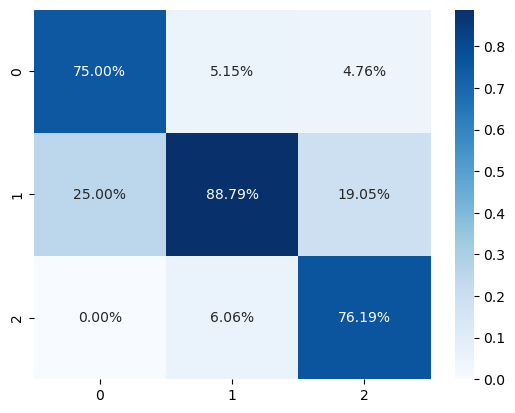

In [35]:
import seaborn as sns
sns.heatmap(conf_m/np.sum(conf_m,axis=0), annot=True, fmt='.2%', cmap='Blues')

In [36]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

        down       0.75      0.14      0.23       173
        null       0.89      1.00      0.94      2563
          up       0.76      0.08      0.15       190

    accuracy                           0.89      2926
   macro avg       0.80      0.41      0.44      2926
weighted avg       0.87      0.89      0.85      2926



Overall, it seems like a useful model. However it is spurious that the precision is at exactly 75%. 

More ways to improve the model would be to 
- get more data
- add other symbols, like ETH, EUR/USD pair, S&P 500, etc.

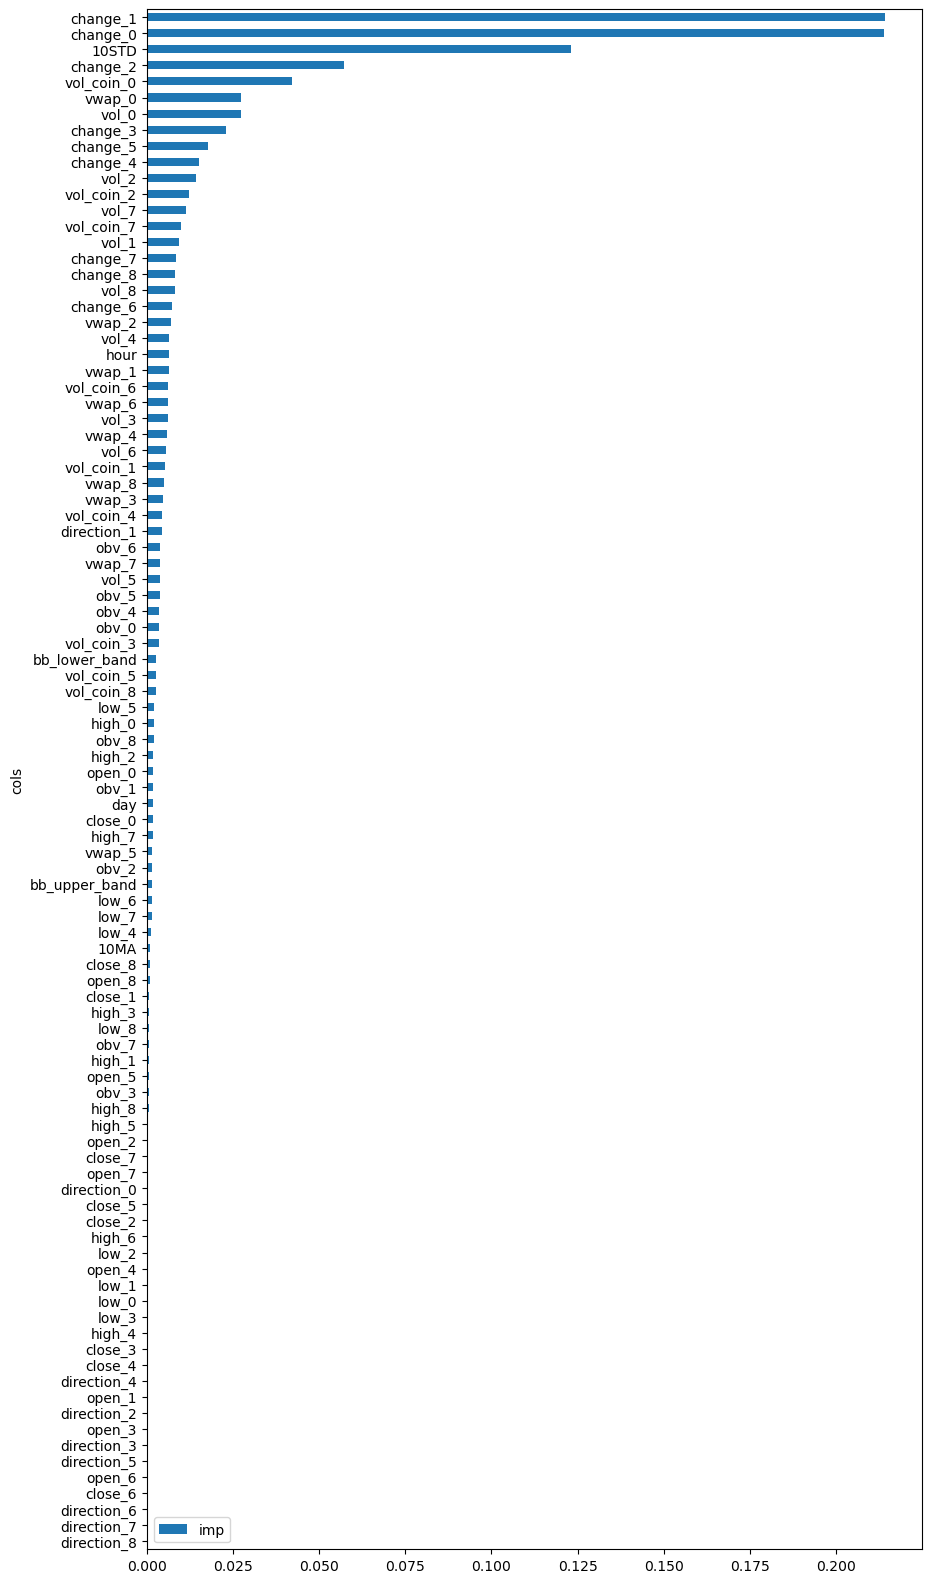

In [37]:
pd.DataFrame(dict(cols=X_train.columns, imp=xg.feature_importances_)).sort_values(by=['imp']).plot('cols', 'imp', 'barh',figsize=(10,20));

In [38]:
# only works for binary classifier
# from sklearn.metrics import RocCurveDisplay
# RocCurveDisplay.from_estimator(xg, X_test, y_test)

In [39]:
import pickle

# Save the model to a file
with open('../bb-bot/src/xgboost_model.pkl', 'wb') as file:
    pickle.dump(xg, file)


In [40]:

# Load the model from the file
with open('../bb-bot/src/xgboost_model.pkl', 'rb') as file:
    model = pickle.load(file)


In [41]:
X_test.head(1)

,day,hour,10MA,10STD,bb_upper_band,bb_lower_band,open_0,high_0,low_0,close_0,...,open_8,high_8,low_8,close_8,vol_8,vol_coin_8,vwap_8,obv_8,change_8,direction_8
8788,31,12,27226.45,25.003078,27276.456155,27176.443845,27222.7,27225.3,27211.8,27225.3,...,27249.0,27276.0,27238.4,27238.5,1.062671e+07,389.868,0.002563,2.675012e+09,-2.5,-1.0


In [42]:
pred = model.predict(X_test.head(1))
pred

array(['null'], dtype=object)

In [43]:
xg.feature_names_in_

array(['day', 'hour', '10MA', '10STD', 'bb_upper_band', 'bb_lower_band',
       'open_0', 'high_0', 'low_0', 'close_0', 'vol_0', 'vol_coin_0',
       'vwap_0', 'obv_0', 'change_0', 'direction_0', 'open_1', 'high_1',
       'low_1', 'close_1', 'vol_1', 'vol_coin_1', 'vwap_1', 'obv_1',
       'change_1', 'direction_1', 'open_2', 'high_2', 'low_2', 'close_2',
       'vol_2', 'vol_coin_2', 'vwap_2', 'obv_2', 'change_2',
       'direction_2', 'open_3', 'high_3', 'low_3', 'close_3', 'vol_3',
       'vol_coin_3', 'vwap_3', 'obv_3', 'change_3', 'direction_3',
       'open_4', 'high_4', 'low_4', 'close_4', 'vol_4', 'vol_coin_4',
       'vwap_4', 'obv_4', 'change_4', 'direction_4', 'open_5', 'high_5',
       'low_5', 'close_5', 'vol_5', 'vol_coin_5', 'vwap_5', 'obv_5',
       'change_5', 'direction_5', 'open_6', 'high_6', 'low_6', 'close_6',
       'vol_6', 'vol_coin_6', 'vwap_6', 'obv_6', 'change_6',
       'direction_6', 'open_7', 'high_7', 'low_7', 'close_7', 'vol_7',
       'vol_coin_7', 'vw

# use live data

In [44]:
import requests
import time
import pandas as pd

# Define the endpoint and parameters
base_url = "https://api-testnet.bybit.com"
endpoint = "/v5/market/kline"
symbol = "BTCUSD"  # Example trading pair
interval = "1"    # Kline interval, e.g., "1", "5", "15", "60", "240", etc.
limit = 4        # Number of klines to fetch
start_time = int(time.time()) - 3600 * 24  # Start time in seconds (e.g., 24 hours ago)

# Construct the URL
url = f"{base_url}{endpoint}?category=linear&symbol={symbol}&interval={interval}&limit={limit}"#&start_time={start_time}"

# Make the GET request
response = requests.get(url,headers={}, data={})
data = response.json() 

print(data)
print(pd.Timestamp(data["time"],unit="ms"))
print(data["result"]["list"])



{'retCode': 0, 'retMsg': 'OK', 'result': {'symbol': 'BTCUSD', 'category': 'linear', 'list': [['1717343100000', '68112', '68112', '68089', '68089', '368907', '5.41780079'], ['1717343040000', '68099', '68112', '68099', '68112', '204', '0.00299537'], ['1717342980000', '68088.5', '68102.5', '68088.5', '68099', '326503', '4.79441399'], ['1717342920000', '68114.5', '68114.5', '68088', '68088.5', '339862', '4.99001248']]}, 'retExtInfo': {}, 'time': 1717343125174}
2024-06-02 15:45:25.174000
[['1717343100000', '68112', '68112', '68089', '68089', '368907', '5.41780079'], ['1717343040000', '68099', '68112', '68099', '68112', '204', '0.00299537'], ['1717342980000', '68088.5', '68102.5', '68088.5', '68099', '326503', '4.79441399'], ['1717342920000', '68114.5', '68114.5', '68088', '68088.5', '339862', '4.99001248']]
